In [450]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [451]:
df = pd.read_csv("/Users/khushil/MLASS2/adult.data")

Preprocessing

In [452]:
# Preprocessing
cols = df.columns
num_cols = df._get_numeric_data().columns
num_cols
cat_cols = list(set(cols) - set(num_cols))


# Removing the target column
cat_cols.remove(' <=50K')

for col in cat_cols:
    df[col] = df[col].replace(' ?', np.NaN)

for x in cat_cols:
    mode_excluding_null = df[x].dropna().mode().values[0]
    df[x] = df[x].fillna(mode_excluding_null)

for x in num_cols:
    mean_excluding_null = df[x].mean(skipna=True)
    df[x] = df[x].fillna(mean_excluding_null)

df.isna().sum().sum()

# Encoding
target = ' <=50K'
df[target] = df[target].replace(' <=50K', 0)
df[target] = df[target].replace(' >50K', 1)

df2 = df
df3 = df


In [453]:
# use sklearn to split into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)
print(test.shape)

# drop the target column from the test
store = test[target]
test = test.drop(target, axis=1)
print(test.shape)


# print all the unique values in the target column
print(train[' Never-married'].unique())

(10745, 15)
(10745, 14)
[' Married-civ-spouse' ' Widowed' ' Never-married' ' Divorced'
 ' Separated' ' Married-spouse-absent' ' Married-AF-spouse']


In [454]:
# Laplace Smoothing on categorical features of the training set
def laplace_smoothing_Cat_Feature(feature, value):
    # Return the number of rows for which feature is equal to value and target is 0
    num_0 = train[(train[feature] == value) & (train[target] == 0)].shape[0]
    # Return the number of rows for which feature is equal to value and target is 1
    num_1 = train[(train[feature] == value) & (train[target] == 1)].shape[0]

    count_0 = train[train[target] == 0].shape[0]
    count_1 = train[train[target] == 1].shape[0]
    # calculate the conditional probability
    pp_0 = (num_0 + 1) / (count_0 + len(train[feature].unique()))
    pp_1 = (num_1 + 1) / (count_1 + len(train[feature].unique()))
    return pd.Series([pp_0, pp_1], index=['<=50K', '>50K'])

In [455]:
#Returns a series that contains the values of the columns < 50K and >50K
def pp_Target():
    # Count the number of 0 and 1 in the target column
    count_0 = train[target].value_counts()[0]
    count_1 = train[target].value_counts()[1]
    pp_0 = count_0 / (count_0 + count_1)
    pp_1 = count_1 / (count_0 + count_1)
    return pd.Series([pp_0, pp_1], index=['<=50K', '>50K']) 


# A function that calculates the conidtional probability of a feature given the target
def pp_Cat_Feature(feature, value):
    # count the number of 0 and 1 in the target column
    count_0 = (train[target].value_counts())[0]
    count_1 = (train[target].value_counts())[1]
    # count the number of 0 and 1 in the target column where the feature is equal to the value
    num_0 = 0
    num_1 = 0
    
    # Return the number of rows for which feature is equal to value and target is 0
    num_0 = train[(train[feature] == value) & (train[target] == 0)].shape[0]
    # Return the number of rows for which feature is equal to value and target is 1
    num_1 = train[(train[feature] == value) & (train[target] == 1)].shape[0]

    # calculate the conditional probability
    pp_0 = (num_0 / count_0)
    pp_1 = (num_1 / count_1)
    return pd.Series([pp_0, pp_1], index=['<=50K', '>50K'])


# Create a function that maps column names in df to index
def get_col_index(col_name):
    return df.columns.get_loc(col_name)

In [456]:
temp_pp = pp_Target()
# function that calculates conditional probability of all unique values of a categorical feature and store it in a dictionary
def lap_get_pp_Cat_Feature(feature):
    # get the unique values of the feature
    unique_values = train[feature].unique()
    # create a dictionary to store the conditional probability
    lap_pp_dict = {}
    for value in unique_values:
        lap_pp_dict[value] = laplace_smoothing_Cat_Feature(feature, value)
    return lap_pp_dict

# function that calculates conditional probability of all unique values of a categorical feature and store it in a dictionary
def get_pp_Cat_Feature(feature):
    # get the unique values of the feature
    unique_values = train[feature].unique()
    # create a dictionary to store the conditional probability
    pp_dict = {}
    for value in unique_values:
        pp_dict[value] = pp_Cat_Feature(feature, value)
    return pp_dict

# function that calculates conditional probability of all unique values of a numerical feature and store it in a dictionary
def get_pp_Num_Feature(feature):
    pp_dict = {}
    mean_0 = train[feature][train[target] == 0].mean()
    std_0 = train[feature][train[target] == 0].std()
    mean_1 = train[feature][train[target] == 1].mean()
    std_1 = train[feature][train[target] == 1].std()
    pp_dict['mean_0'] = mean_0
    pp_dict['std_0'] = std_0
    pp_dict['mean_1'] = mean_1
    pp_dict['std_1'] = std_1
    return pp_dict

In [457]:
print(test.shape)
# call get_pp_Cat_Feature for each categorical feature and store the result in a dictionary
pp_dict = {}
for feature in cat_cols:
    pp_dict[feature] = get_pp_Cat_Feature(feature)

lap_pp_dict = {}
for feature in cat_cols:
    lap_pp_dict[feature] = lap_get_pp_Cat_Feature(feature)

# call get_pp_Num_Feature for each numerical feature and store the result in a dictionary
pp_dict_num = {}
for feature in num_cols:
    pp_dict_num[feature] = get_pp_Num_Feature(feature)

(10745, 14)


In [458]:
# A function that classifies a new instance using the Naive Bayes algorithm
def classify(instance):

    # calculate the prior probability of the target
    pp_target = temp_pp
    tmp = pd.Series([0,0], index=['<=50K', '>50K'])

    # calculate the conditional probability of each feature given the target
    pp_cat_features = []
    pp_num_features = []

    for feature in cat_cols:
        ind = get_col_index(feature)
        pp_cat_features.append(pp_dict[feature][instance[ind]])
    

    for feature in num_cols:
        ind = get_col_index(feature)
        a = (stats.norm.pdf(instance[ind], pp_dict_num[feature]['mean_0'], pp_dict_num[feature]['std_0']))
        b = (stats.norm.pdf(instance[ind], pp_dict_num[feature]['mean_1'], pp_dict_num[feature]['std_1']))
        pp_num_features.append(pd.Series([a, b], index=['<=50K', '>50K']))
    
    # calculate the posterior probability of the target given the features
    for i in range(len(cat_cols)):
        if pp_cat_features[i][0] == 0:
            return 1
        if pp_cat_features[i][1] == 0:
            return 0
        tmp = tmp + np.log(pp_cat_features[i])
    for i in range(len(num_cols)):
        if pp_num_features[i][0] == 0:
            return 1
        if pp_num_features[i][1] == 0:
            return 0
        tmp = tmp + np.log(pp_num_features[i])

    # classify the instance
    tmp = tmp + np.log(pp_target)
    if tmp[0] > tmp[1]:
        return 0
    else:
        return 1

In [459]:
# A function that classifies a new instance using the Naive Bayes algorithm
def lap_classify(instance):

    # calculate the prior probability of the target
    pp_target = temp_pp
    tmp = pd.Series([0,0], index=['<=50K', '>50K'])

    # calculate the conditional probability of each feature given the target
    pp_cat_features = []
    pp_num_features = []

    for feature in cat_cols:
        ind = get_col_index(feature)
        pp_cat_features.append(lap_pp_dict[feature][instance[ind]])
    

    for feature in num_cols:
        ind = get_col_index(feature)
        a = (stats.norm.pdf(instance[ind], pp_dict_num[feature]['mean_0'], pp_dict_num[feature]['std_0']))
        b = (stats.norm.pdf(instance[ind], pp_dict_num[feature]['mean_1'], pp_dict_num[feature]['std_1']))
        pp_num_features.append(pd.Series([a, b], index=['<=50K', '>50K']))
    
    # calculate the posterior probability of the target given the features
    for i in range(len(cat_cols)):
        if pp_cat_features[i][0] == 0:
            return 1
        if pp_cat_features[i][1] == 0:
            return 0
        tmp = tmp + np.log(pp_cat_features[i])
    for i in range(len(num_cols)):
        if pp_num_features[i][0] == 0:
            return 1
        if pp_num_features[i][1] == 0:
            return 0
        tmp = tmp + np.log(pp_num_features[i])

    # classify the instance
    tmp = tmp + np.log(pp_target)
    if tmp[0] > tmp[1]:
        return 0
    else:
        return 1

In [460]:
# Calculate the accuracy of the model
def get_accuracy(test, val):
    count = 0
    for i in range(test.shape[0]):
        if test.iloc[i][val] == test.iloc[i][target]:
            count += 1
    return count / test.shape[0]

def precision(test):
    tp = 0
    fp = 0
    for i in range(test.shape[0]):
        if test.iloc[i][val] == 1 and test.iloc[i][target] == 1:
            tp += 1
        if test.iloc[i][val] == 1 and test.iloc[i][target] == 0:
            fp += 1
    return tp / (tp + fp)

def recall(test):
    tp = 0
    fn = 0
    for i in range(test.shape[0]):
        if test.iloc[i]['predicted'] == 1 and test.iloc[i][target] == 1:
            tp += 1
        if test.iloc[i]['predicted'] == 0 and test.iloc[i][target] == 1:
            fn += 1
    return tp / (tp + fn)

def f1_score(test):
    p = precision(test)
    r = recall(test)
    return 2 * p * r / (p + r)

In [461]:
# Calculate the accuracy of the model
def get_accuracy(test, val):
    count = 0
    for i in range(test.shape[0]):
        if test.iloc[i][val] == test.iloc[i][target]:
            count += 1
    return count / test.shape[0]

def precision(test, val):
    tp = 0
    fp = 0
    for i in range(test.shape[0]):
        if test.iloc[i][val] == 1 and test.iloc[i][target] == 1:
            tp += 1
        if test.iloc[i][val] == 1 and test.iloc[i][target] == 0:
            fp += 1
    return tp / (tp + fp)

def recall(test, val):
    tp = 0
    fn = 0
    for i in range(test.shape[0]):
        if test.iloc[i][val] == 1 and test.iloc[i][target] == 1:
            tp += 1
        if test.iloc[i][val] == 0 and test.iloc[i][target] == 1:
            fn += 1
    return tp / (tp + fn)

def f1_score(test , val):
    p = precision(test, val)
    r = recall(test, val)
    return 2 * p * r / (p + r)

In [462]:
# Create 2 lists to store the accuracy, precision, recall and f1 score of the model and the model with Laplace Smoothing
acc = []
pre = []
rec = []
f1 = []
acc_lap = []
pre_lap = []
rec_lap = []
f1_lap = []

# Calculate the accuracy, precision, recall and f1 score of the model and the model with Laplace Smoothing for 10 times
for i in range(10):
    train, test = train_test_split(df, test_size=0.2)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    store = test[target]
    test = test.drop(target, axis=1)
    test['predicted'] = test.apply(classify, axis=1)
    test.insert(0, target, store)
    val = 'predicted'
    acc.append(get_accuracy(test, val))
    pre.append(precision(test, val))
    rec.append(recall(test, val))
    f1.append(f1_score(test, val))

    #Laplace Smoothing
    test2 = test.drop(target, axis=1)
    test2 = test2.drop('predicted', axis=1)
    test2['laplace_predicted'] = test2.apply(lap_classify, axis=1)
    val = 'laplace_predicted'
    test2.insert(0, target, store)
    acc_lap.append(get_accuracy(test2, val))
    pre_lap.append(precision(test2, val))
    rec_lap.append(recall(test2, val))
    f1_lap.append(f1_score(test2,val))
    print("End of ", i + 1, "th iteration")

End of  1 th iteration
End of  2 th iteration
End of  3 th iteration
End of  4 th iteration
End of  5 th iteration
End of  6 th iteration
End of  7 th iteration
End of  8 th iteration
End of  9 th iteration
End of  10 th iteration


In [463]:
# Tabulate the results
results = pd.DataFrame({'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1 Score': f1})
results.insert(0, 'Model', 'Model')
results_lap = pd.DataFrame({'Accuracy': acc_lap, 'Precision': pre_lap, 'Recall': rec_lap, 'F1 Score': f1_lap})
results_lap.insert(0, 'Model', 'Model:L')
results = results.reset_index(drop=True)
results_lap = results_lap.reset_index(drop=True)

In [464]:
print("Without Laplace Smoothing:")
results

Without Laplace Smoothing:


,Model,Accuracy,Precision,Recall,F1 Score
0,Model,0.833231,0.709677,0.519464,0.599853
1,Model,0.839988,0.709378,0.511721,0.594553
2,Model,0.838452,0.712236,0.542765,0.616058
3,Model,0.837838,0.713051,0.532602,0.609756
4,Model,0.828471,0.716949,0.519337,0.602350
5,Model,0.835381,0.720286,0.515016,0.600596
6,Model,0.835842,0.732456,0.522201,0.609712
7,Model,0.829085,0.709705,0.522360,0.601789
8,Model,0.834920,0.712424,0.524297,0.604052
9,Model,0.832310,0.703993,0.519206,0.597642


In [465]:
# Calculate the average accuracy, precision, recall and f1 score of the model and the model with Laplace Smoothing
print("Average Accuracy: ", np.mean(acc))
print("Average Precision: ", np.mean(pre))
print("Average Recall: ", np.mean(rec))
print("Average F1 Score: ", np.mean(f1))

Average Accuracy:  0.8345515970515971
Average Precision:  0.714015554036631
Average Recall:  0.5228969698513438
Average F1 Score:  0.6036359257504978


Text(0.5, 1.0, 'Confusion matrix of the model without laplace smoothing')

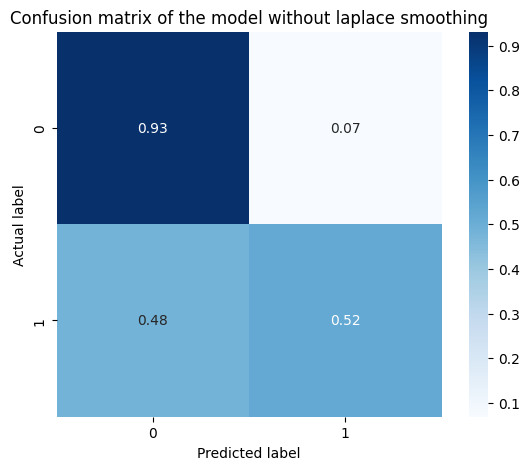

In [466]:
# Plot the confusion matrix of the model
cm = confusion_matrix(test[target], test['predicted'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of the model without laplace smoothing')

In [467]:
print("With Laplace Smoothing:")
results_lap

With Laplace Smoothing:


,Model,Accuracy,Precision,Recall,F1 Score
0,Model:L,0.832617,0.708297,0.517549,0.598083
1,Model:L,0.840295,0.710306,0.512391,0.595331
2,Model:L,0.838299,0.712352,0.541479,0.615272
3,Model:L,0.837531,0.712554,0.531311,0.608728
4,Model:L,0.828471,0.716949,0.519337,0.602350
5,Model:L,0.835074,0.719785,0.513738,0.599553
6,Model:L,0.835534,0.731986,0.520951,0.608696
7,Model:L,0.829699,0.711392,0.523602,0.603220
8,Model:L,0.834306,0.711053,0.522379,0.602285
9,Model:L,0.832463,0.704250,0.519846,0.598158


In [468]:
# Calculate the average accuracy, precision, recall and f1 score of the model and the model with Laplace Smoothing
print("Average Accuracy with Laplace Smoothing: ", np.mean(acc_lap))
print("Average Precision with Laplace Smoothing: ", np.mean(pre_lap))
print("Average Recall with Laplace Smoothing: ", np.mean(rec_lap))
print("Average F1 Score with Laplace Smoothing: ", np.mean(f1_lap))

Average Accuracy with Laplace Smoothing:  0.8344287469287469
Average Precision with Laplace Smoothing:  0.7138924917759029
Average Recall with Laplace Smoothing:  0.5222583220693078
Average F1 Score with Laplace Smoothing:  0.6031674865323613


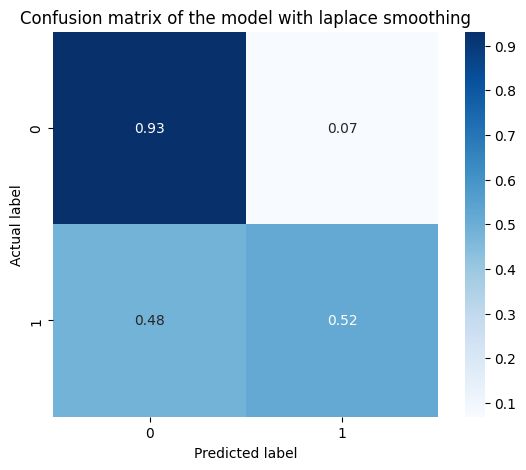

In [469]:
# Plot the confusion matrix of the model with Laplace Smoothing
cm = confusion_matrix(test2[target], test2['laplace_predicted'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of the model with laplace smoothing')
plt.show()

In [470]:
# One Hot Encode
print(cat_cols)
print(num_cols)
df2 = pd.get_dummies(df, columns=cat_cols)
df3 = pd.get_dummies(df, columns=cat_cols)
print("Dimension of df2: ", df2.shape)
print("Dimension of df3: ", df3.shape)

[' State-gov', ' Bachelors', ' White', ' Not-in-family', ' Male', ' Never-married', ' United-States', ' Adm-clerical']
Index(['39', ' 77516', ' 13', ' 2174', ' 0', ' 40'], dtype='object')
Dimension of df2:  (32560, 106)
Dimension of df3:  (32560, 106)


Resutls of Logistic Regression Model:
Accuracy:  0.7920761670761671
Precision:  0.6878306878306878
Recall:  0.2488832163369496
F1 Score:  0.3655107778819119


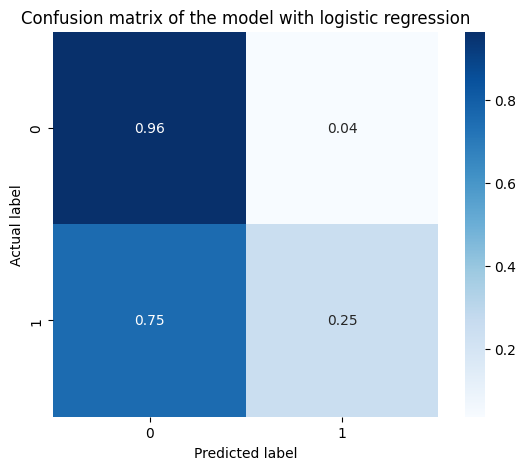

In [471]:
# Run the model with logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training set and test set
train, test = train_test_split(df2, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
store = test[target]
test = test.drop(target, axis=1)

# Train the model
logreg = LogisticRegression()
logreg.fit(train.drop(target, axis=1), train[target])

# Predict the test set
test['predicted'] = logreg.predict(test)
test.insert(0, target, store)
val = 'predicted'

# Calculate the accuracy, precision, recall and f1 score of the model
print("Resutls of Logistic Regression Model:")
print("Accuracy: ", accuracy_score(test[target], test['predicted']))
print("Precision: ", precision_score(test[target], test['predicted']))
print("Recall: ", recall_score(test[target], test['predicted']))
print("F1 Score: ", f1_score(test[target], test['predicted']))

# Plot the confusion matrix of the model
cm = confusion_matrix(test[target], test['predicted'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of the model with logistic regression')
plt.show()

Resuls of KNN: 
Accuracy:  0.7670454545454546
Precision:  0.5301478953356087
Recall:  0.2968152866242038
F1 Score:  0.3805634953042058


<function matplotlib.pyplot.show(close=None, block=None)>

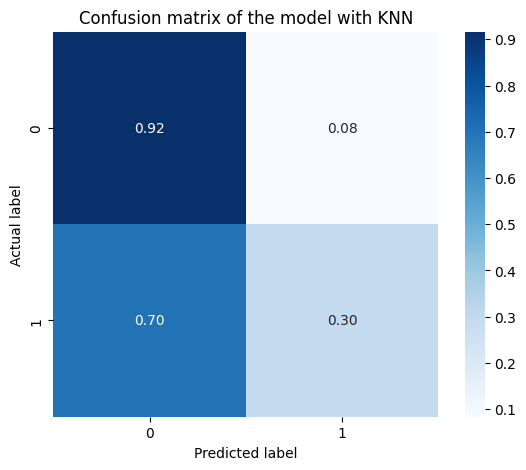

In [472]:
# Run the model with KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training set and test set
train, test = train_test_split(df3, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
store = test[target]
test = test.drop(target, axis=1)

# Train the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train.drop(target, axis=1), train[target])

# Predict the test set
test['predicted'] = knn.predict(test)
test.insert(0, target, store)
val = 'predicted'

# Calculate the accuracy, precision, recall and f1 score of the model
print("Resuls of KNN: ")
print("Accuracy: ", accuracy_score(test[target], test['predicted']))
print("Precision: ", precision_score(test[target], test['predicted']))
print("Recall: ", recall_score(test[target], test['predicted']))
print("F1 Score: ", f1_score(test[target], test['predicted']))

# Generate the confusion matrix plot
cm = confusion_matrix(test[target], test['predicted'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of the model with KNN')
plt.show
